In [1]:
from config.cfg_algorithm import CFG_MODEL
from config.cfg_general import CFG_GENERAL
from config.cfg_dataset import CFG_DATASET
import os
from runner.builder import build_model
from data.data_loader import build_dataset
from utils.__init__ import config_md5
import torch

data = ["PEMS08","T-Drive","CHIBike","NYCTaxi"][0]
algo = "PDFormer"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
epochs = 10
val_interval = 1
out_dir = "./checkpoints"


model_args = CFG_MODEL[algo](data, CFG_DATASET[data]["NUM_NODES"],
                        CFG_GENERAL.DATASET.HISTORY_SEQ_LEN,
                        CFG_GENERAL.DATASET.FUTURE_SEQ_LEN,
                        not CFG_GENERAL.DATASET.NORM_EACH_CHANNEL,
                        CFG_DATASET[data].get("STEPS_PER_DAY",None))

md5 = config_md5(CFG_GENERAL, CFG_DATASET[data], model_args)
ckpt_save_dir = os.path.join(out_dir, "_".join([data, algo, str(epochs)]),md5)
if not os.path.isdir(ckpt_save_dir):
    os.makedirs(ckpt_save_dir)

models = build_model(CFG_GENERAL, model_args)
datasets = build_dataset(CFG_GENERAL, CFG_DATASET[data])
future_data, history_data = next(iter(datasets["train"]))
future_data, history_data = future_data.to(device), history_data.to(device)

model = models["model"].to(device)
out = model(history_data,history_data,0,0,False)
out.shape,future_data.shape, history_data.shape

(torch.Size([32, 12, 170, 1]),
 torch.Size([32, 12, 170, 3]),
 torch.Size([32, 12, 170, 3]))

数据预处理阶段获得的先验知识

In [2]:
model_args["PARAM"]["dtw_matrix"].shape, model_args["PARAM"]["adj_mx"].shape, model_args["PARAM"]["sd_mx"], model_args["PARAM"]["sh_mx"].shape, model_args["PARAM"]["pattern_keys"].shape 

((170, 170), (170, 170), None, (170, 170), (16, 3, 1))

### 框架  
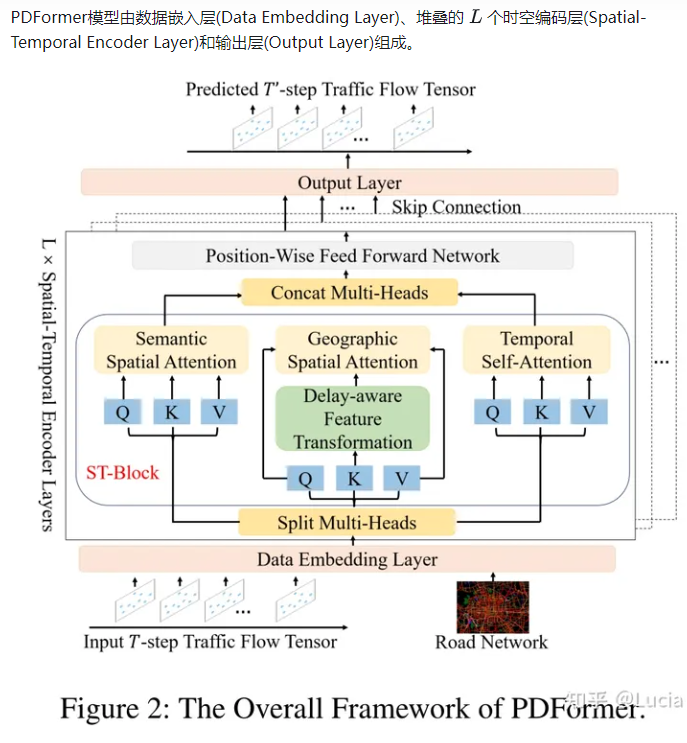

In [3]:
import scipy.sparse as sp
import numpy as np
import torch.nn as nn
import math
import torch.nn.functional as F
from functools import partial

sh_mx = model_args["PARAM"]["sh_mx"]
pattern_keys = torch.from_numpy(model_args["PARAM"]["pattern_keys"]).float().to(device)
adj_mx = model_args["PARAM"]["adj_mx"]
feature_dim_b = model_args["PARAM"]["feature_dim"]
embed_dim = model_args["PARAM"]["embed_dim"]
lape_dim = model_args["PARAM"]["lape_dim"]
add_time_in_day = model_args["PARAM"]["add_time_in_day"]
add_day_in_week = model_args["PARAM"]["add_day_in_week"]
drop = model_args["PARAM"]["drop"]
ext_dim = model_args["PARAM"]["ext_dim"]
output_dim = model_args["PARAM"]["output_dim"]
s_attn_size = model_args["PARAM"]["s_attn_size"]
num_nodes = model_args["PARAM"]["num_nodes"]
far_mask_delta = model_args["PARAM"]["far_mask_delta"]
dtw_delta = model_args["PARAM"]["dtw_delta"]
dtw_matrix = model_args["PARAM"]["dtw_matrix"]
feature_dim_b, embed_dim, lape_dim, add_time_in_day, add_day_in_week, drop, ext_dim, output_dim, s_attn_size,pattern_keys.shape,sh_mx.shape,num_nodes,far_mask_delta,dtw_delta,dtw_matrix.shape

(3,
 64,
 8,
 True,
 True,
 0,
 2,
 1,
 3,
 torch.Size([16, 3, 1]),
 (170, 170),
 170,
 7,
 5,
 (170, 170))

### 数据嵌入层
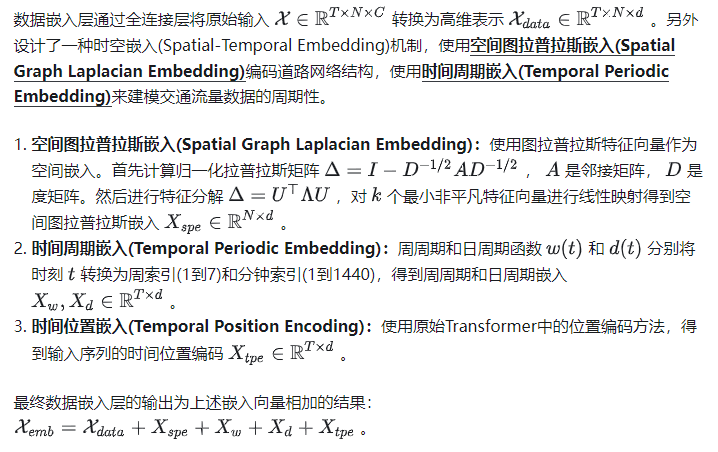  

In [4]:
def _calculate_normalized_laplacian(adj):
    adj = sp.coo_matrix(adj)
    d = np.array(adj.sum(1))
    isolated_point_num = np.sum(np.where(d, 0, 1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    normalized_laplacian = sp.eye(adj.shape[0]) - adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()
    return normalized_laplacian, isolated_point_num

def _cal_lape(adj_mx):
    lape_dim = 8
    L, isolated_point_num = _calculate_normalized_laplacian(adj_mx)
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort()
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:, idx])

    laplacian_pe = torch.from_numpy(EigVec[:, isolated_point_num + 1: lape_dim + isolated_point_num + 1]).float()
    laplacian_pe.require_grad = False
    return laplacian_pe

# 拉普拉斯矩阵 (170, 8)
lap_mx = _cal_lape(adj_mx).to(device)
lap_mx.shape

torch.Size([170, 8])

获得时空嵌入

In [5]:
class TokenEmbedding(nn.Module):
    def __init__(self, input_dim, embed_dim, norm_layer=None):
        super().__init__()
        self.token_embed = nn.Linear(input_dim, embed_dim, bias=True)
        self.norm = norm_layer(embed_dim) if norm_layer is not None else nn.Identity()

    def forward(self, x):
        x = self.token_embed(x)
        x = self.norm(x)
        return x
    
class PositionalEncoding(nn.Module):
    def __init__(self, embed_dim, max_len=100):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embed_dim).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)].unsqueeze(2).expand_as(x).detach()
    
class LaplacianPE(nn.Module):
    def __init__(self, lape_dim, embed_dim):
        super().__init__()
        self.embedding_lap_pos_enc = nn.Linear(lape_dim, embed_dim)

    def forward(self, lap_mx):
        lap_pos_enc = self.embedding_lap_pos_enc(lap_mx).unsqueeze(0).unsqueeze(0)
        return lap_pos_enc

feature_dim = feature_dim_b - ext_dim
value_embedding = TokenEmbedding(feature_dim, embed_dim).to(device)
position_encoding = PositionalEncoding(embed_dim).to(device)
minute_size = 1440
daytime_embedding = nn.Embedding(minute_size, embed_dim).to(device)
weekday_size = 7
weekday_embedding = nn.Embedding(weekday_size, embed_dim).to(device)
spatial_embedding = LaplacianPE(lape_dim, embed_dim).to(device)
dropout = nn.Dropout(drop)


# 时空嵌入
x = value_embedding(history_data[:, :, :, :feature_dim])
x += position_encoding(x)
if add_time_in_day:
    x += daytime_embedding((history_data[:, :, :, feature_dim] * minute_size).round().long())
if add_day_in_week:
    x += weekday_embedding(history_data[:, :, :, feature_dim + 1: feature_dim + 8].argmax(dim=3))
x += spatial_embedding(lap_mx)
emb = dropout(x)
emb.shape

torch.Size([32, 12, 170, 64])

对历史数据k-shape聚类，将聚类中心作为历史模式

In [6]:
pattern_embeddings = nn.ModuleList([
            TokenEmbedding(s_attn_size, embed_dim).to(device) for _ in range(output_dim)
        ])

T =  history_data.shape[1]
x_pattern_list = []
for i in range(s_attn_size):
    x_pattern = F.pad(
        x[:, :T + i + 1 - s_attn_size, :, :output_dim],
        (0, 0, 0, 0, s_attn_size - 1 - i, 0),
        "constant", 0,
    ).unsqueeze(-2)
    x_pattern_list.append(x_pattern)
x_patterns = torch.cat(x_pattern_list, dim=-2)  # (B, T, N, s_attn_size, output_dim)

x_pattern_list = []
pattern_key_list = []
for i in range(output_dim):
    x_pattern_list.append(pattern_embeddings[i](x_patterns[..., i]).unsqueeze(-1))
    pattern_key_list.append(pattern_embeddings[i](pattern_keys[..., i]).unsqueeze(-1))
x_patterns = torch.cat(x_pattern_list, dim=-1)
pattern_keys = torch.cat(pattern_key_list, dim=-1)
x_patterns.shape, pattern_keys.shape

(torch.Size([32, 12, 170, 64, 1]), torch.Size([16, 64, 1]))

两个mask矩阵：
- 地理：地理上离得近的权重为1，否则为0
- 语义：历史数据相似的权重为1，否则为0

In [15]:
sh_mx = sh_mx.T
geo_mask = torch.zeros(num_nodes, num_nodes).to(device)
geo_mask[sh_mx >= far_mask_delta] = 1
geo_mask = geo_mask.bool()
sem_mask = torch.ones(num_nodes, num_nodes).to(device)
s_m = dtw_matrix.argsort(axis=1)[:, :dtw_delta]
for i in range(sem_mask.shape[0]):
    sem_mask[i][s_m[i]] = 0
sem_mask = sem_mask.bool()
geo_mask.shape, sem_mask.shape

(torch.Size([170, 170]), torch.Size([170, 170]))

### 时空编码层
时空编码层基于自注意力机制对复杂动态的时空相关性进行建模，包括三个核心组件：空间自注意力(Spatial Self-Attention, SSA)模块用来捕获交通数据中的动态空间相关性、延迟感知特征转换(Delay-aware Feature Transformation, DFT)模块用来建模空间信息传播中的时间延迟、时间自注意力(Temporal Self-Attention, TSA)模块用来捕捉动态和长时间模式。

- 空间自注意力(Spatial Self-Attention, SSA)模块  
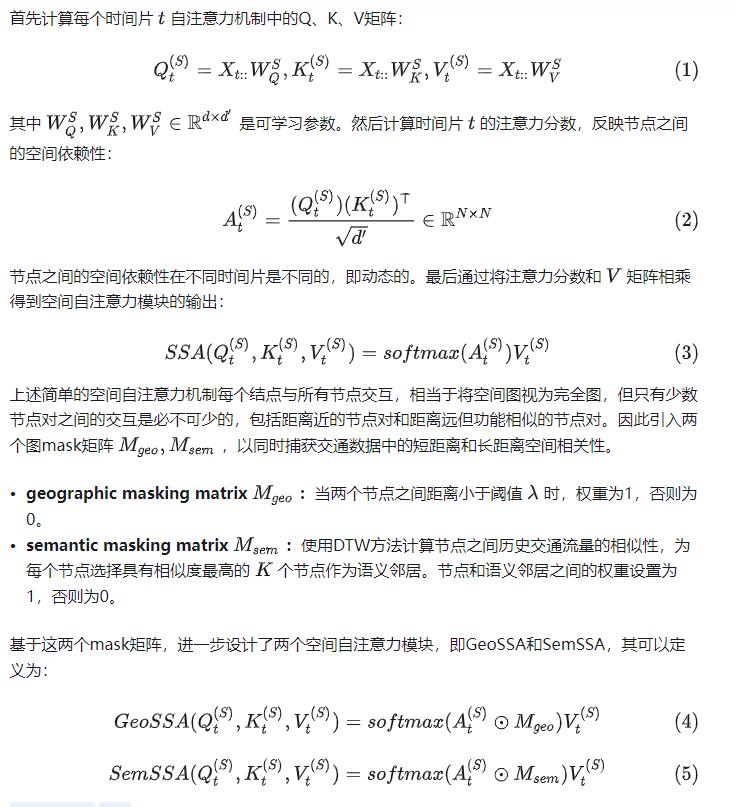  


- 延迟感知特征转换(Delay-aware Feature Transformation, DFT)模块  
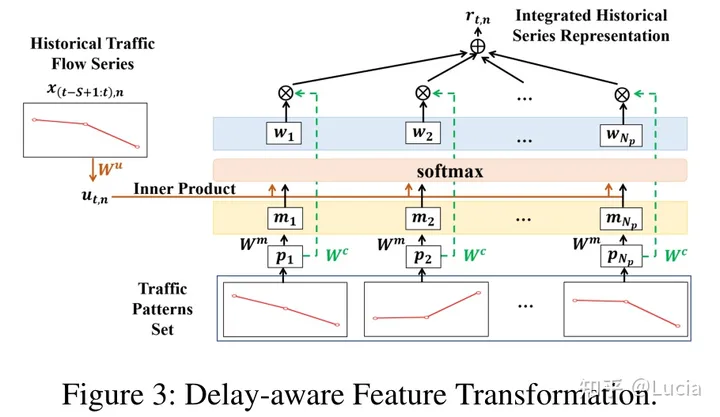  
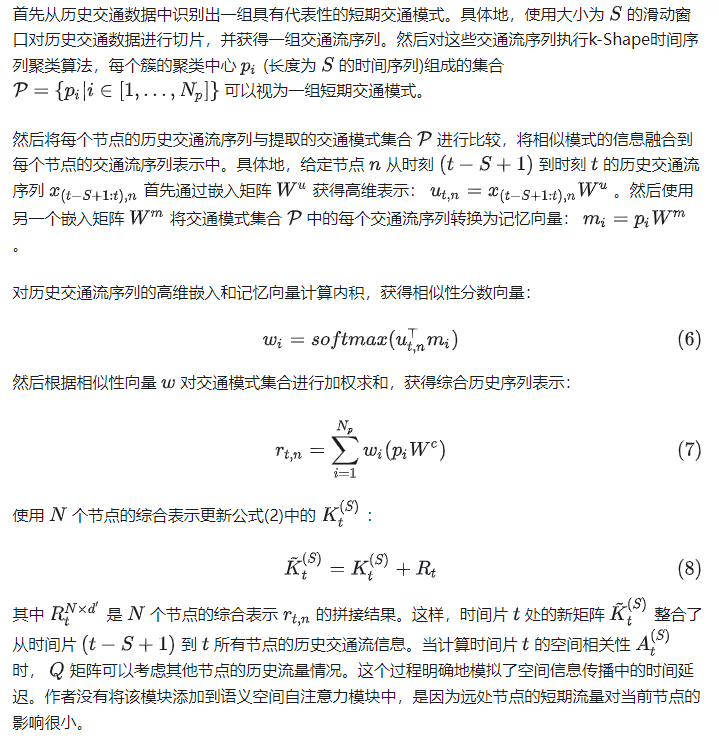  

- 时间自注意力(Temporal Self-Attention, TSA)模块  
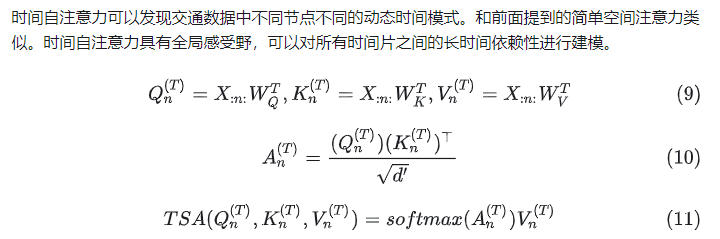  

- 异质注意力融合(Heterogeneous Attention Fusion)  
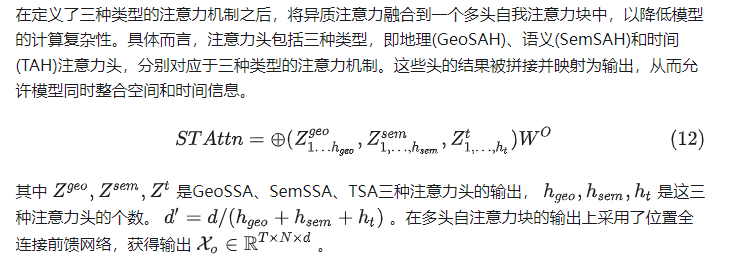  

- 输出层 (Output Layer)  
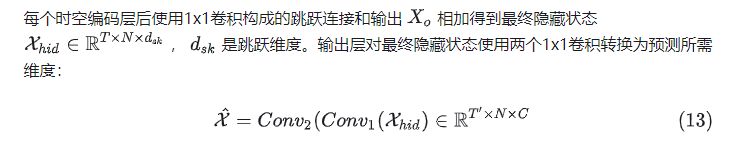

In [16]:
def drop_path(x, drop_prob=0., training=False):
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()
    output = x.div(keep_prob) * random_tensor
    return output

class DropPath(nn.Module):
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class STSelfAttention(nn.Module):
    def __init__(
        self, dim, s_attn_size, t_attn_size, geo_num_heads=4, sem_num_heads=2, t_num_heads=2, qkv_bias=False,
        attn_drop=0., proj_drop=0., device=torch.device('cpu'), output_dim=1,
    ):
        super().__init__()
        assert dim % (geo_num_heads + sem_num_heads + t_num_heads) == 0
        self.geo_num_heads = geo_num_heads
        self.sem_num_heads = sem_num_heads
        self.t_num_heads = t_num_heads
        self.head_dim = dim // (geo_num_heads + sem_num_heads + t_num_heads)
        self.scale = self.head_dim ** -0.5
        self.device = device
        self.s_attn_size = s_attn_size
        self.t_attn_size = t_attn_size
        self.geo_ratio = geo_num_heads / (geo_num_heads + sem_num_heads + t_num_heads)
        self.sem_ratio = sem_num_heads / (geo_num_heads + sem_num_heads + t_num_heads)
        self.t_ratio = 1 - self.geo_ratio - self.sem_ratio
        self.output_dim = output_dim

        self.pattern_q_linears = nn.ModuleList([
            nn.Linear(dim, int(dim * self.geo_ratio)) for _ in range(output_dim)
        ])
        self.pattern_k_linears = nn.ModuleList([
            nn.Linear(dim, int(dim * self.geo_ratio)) for _ in range(output_dim)
        ])
        self.pattern_v_linears = nn.ModuleList([
            nn.Linear(dim, int(dim * self.geo_ratio)) for _ in range(output_dim)
        ])

        self.geo_q_conv = nn.Conv2d(dim, int(dim * self.geo_ratio), kernel_size=1, bias=qkv_bias)
        self.geo_k_conv = nn.Conv2d(dim, int(dim * self.geo_ratio), kernel_size=1, bias=qkv_bias)
        self.geo_v_conv = nn.Conv2d(dim, int(dim * self.geo_ratio), kernel_size=1, bias=qkv_bias)
        self.geo_attn_drop = nn.Dropout(attn_drop)

        self.sem_q_conv = nn.Conv2d(dim, int(dim * self.sem_ratio), kernel_size=1, bias=qkv_bias)
        self.sem_k_conv = nn.Conv2d(dim, int(dim * self.sem_ratio), kernel_size=1, bias=qkv_bias)
        self.sem_v_conv = nn.Conv2d(dim, int(dim * self.sem_ratio), kernel_size=1, bias=qkv_bias)
        self.sem_attn_drop = nn.Dropout(attn_drop)

        self.t_q_conv = nn.Conv2d(dim, int(dim * self.t_ratio), kernel_size=1, bias=qkv_bias)
        self.t_k_conv = nn.Conv2d(dim, int(dim * self.t_ratio), kernel_size=1, bias=qkv_bias)
        self.t_v_conv = nn.Conv2d(dim, int(dim * self.t_ratio), kernel_size=1, bias=qkv_bias)
        self.t_attn_drop = nn.Dropout(attn_drop)

        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, x_patterns, pattern_keys, geo_mask=None, sem_mask=None):
        B, T, N, D = x.shape
        t_q = self.t_q_conv(x.permute(0, 3, 1, 2)).permute(0, 3, 2, 1)
        t_k = self.t_k_conv(x.permute(0, 3, 1, 2)).permute(0, 3, 2, 1)
        t_v = self.t_v_conv(x.permute(0, 3, 1, 2)).permute(0, 3, 2, 1)
        t_q = t_q.reshape(B, N, T, self.t_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        t_k = t_k.reshape(B, N, T, self.t_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        t_v = t_v.reshape(B, N, T, self.t_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        t_attn = (t_q @ t_k.transpose(-2, -1)) * self.scale
        t_attn = t_attn.softmax(dim=-1)
        t_attn = self.t_attn_drop(t_attn)
        t_x = (t_attn @ t_v).transpose(2, 3).reshape(B, N, T, int(D * self.t_ratio)).transpose(1, 2)

        geo_q = self.geo_q_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        geo_k = self.geo_k_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        for i in range(self.output_dim):
            pattern_q = self.pattern_q_linears[i](x_patterns[..., i])
            pattern_k = self.pattern_k_linears[i](pattern_keys[..., i])
            pattern_v = self.pattern_v_linears[i](pattern_keys[..., i])
            pattern_attn = (pattern_q @ pattern_k.transpose(-2, -1)) * self.scale
            pattern_attn = pattern_attn.softmax(dim=-1)
            geo_k += pattern_attn @ pattern_v
        geo_v = self.geo_v_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        geo_q = geo_q.reshape(B, T, N, self.geo_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        geo_k = geo_k.reshape(B, T, N, self.geo_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        geo_v = geo_v.reshape(B, T, N, self.geo_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        geo_attn = (geo_q @ geo_k.transpose(-2, -1)) * self.scale
        if geo_mask is not None:
            geo_attn.masked_fill_(geo_mask, float('-inf'))
        geo_attn = geo_attn.softmax(dim=-1)
        geo_attn = self.geo_attn_drop(geo_attn)
        geo_x = (geo_attn @ geo_v).transpose(2, 3).reshape(B, T, N, int(D * self.geo_ratio))

        sem_q = self.sem_q_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        sem_k = self.sem_k_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        sem_v = self.sem_v_conv(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
        sem_q = sem_q.reshape(B, T, N, self.sem_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        sem_k = sem_k.reshape(B, T, N, self.sem_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        sem_v = sem_v.reshape(B, T, N, self.sem_num_heads, self.head_dim).permute(0, 1, 3, 2, 4)
        sem_attn = (sem_q @ sem_k.transpose(-2, -1)) * self.scale
        if sem_mask is not None:
            sem_attn.masked_fill_(sem_mask, float('-inf'))
        sem_attn = sem_attn.softmax(dim=-1)
        sem_attn = self.sem_attn_drop(sem_attn)
        sem_x = (sem_attn @ sem_v).transpose(2, 3).reshape(B, T, N, int(D * self.sem_ratio))

        x = self.proj(torch.cat([t_x, geo_x, sem_x], dim=-1))
        x = self.proj_drop(x)
        return x


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
    
class STEncoderBlock(nn.Module):

    def __init__(
        self, dim, s_attn_size, t_attn_size, geo_num_heads=4, sem_num_heads=2, t_num_heads=2, mlp_ratio=4., qkv_bias=True, drop=0., attn_drop=0.,
        drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, device=torch.device('cpu'), type_ln="pre", output_dim=1,
    ):
        super().__init__()
        self.type_ln = type_ln
        self.norm1 = norm_layer(dim)
        self.st_attn = STSelfAttention(
            dim, s_attn_size, t_attn_size, geo_num_heads=geo_num_heads, sem_num_heads=sem_num_heads, t_num_heads=t_num_heads, qkv_bias=qkv_bias,
            attn_drop=attn_drop, proj_drop=drop, device=device, output_dim=output_dim,
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x, x_patterns, pattern_keys, geo_mask=None, sem_mask=None):
        if self.type_ln == 'pre':
            x = x + self.drop_path(self.st_attn(self.norm1(x), x_patterns, pattern_keys, geo_mask=geo_mask, sem_mask=sem_mask))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
        elif self.type_ln == 'post':
            x = self.norm1(x + self.drop_path(self.st_attn(x, x_patterns, pattern_keys, geo_mask=geo_mask, sem_mask=sem_mask)))
            x = self.norm2(x + self.drop_path(self.mlp(x)))
        return x
    


t_attn_size = model_args["PARAM"]["t_attn_size"]
geo_num_heads = model_args["PARAM"]["geo_num_heads"]
sem_num_heads = model_args["PARAM"]["sem_num_heads"]
t_num_heads = model_args["PARAM"]["t_num_heads"]
mlp_ratio = model_args["PARAM"]["mlp_ratio"]
qkv_bias = model_args["PARAM"]["qkv_bias"]
attn_drop = model_args["PARAM"]["attn_drop"]
type_ln = model_args["PARAM"]["type_ln"]
enc_depth = model_args["PARAM"]["enc_depth"]
drop_path = model_args["PARAM"]["drop_path"]
enc_dpr = [x.item() for x in torch.linspace(0, drop_path, enc_depth)]

i=0
enc_block = STEncoderBlock(
                dim=embed_dim, s_attn_size=s_attn_size, t_attn_size=t_attn_size, geo_num_heads=geo_num_heads, sem_num_heads=sem_num_heads, t_num_heads=t_num_heads,
                mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop, attn_drop=attn_drop, drop_path=enc_dpr[i], act_layer=nn.GELU,
                norm_layer=partial(nn.LayerNorm, eps=1e-6), device=device, type_ln=type_ln, output_dim=output_dim,
            ).to(device)


enc = enc_block(emb,x_patterns,pattern_keys,geo_mask,sem_mask)
enc.shape

torch.Size([32, 12, 170, 64])